### Adapt the PINN & FBPINN to 2D case

$$
\begin{cases}
- \left( \dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} \right) = f & \text{in } \Omega, \\
u = 0 & \text{on } \partial \Omega,
\end{cases}
\quad \text{where } \Omega = [0,1]^2
$$

###  Exact Solution:

$$
u_{\text{true}} = \sin(2\pi x) \cdot \sin(2\pi y)
$$

### Forcing Term:

$$
f(x, y) = -8\pi^2 \sin(2\pi x) \cdot \sin(2\pi y), \quad (x, y) \in \Omega
$$

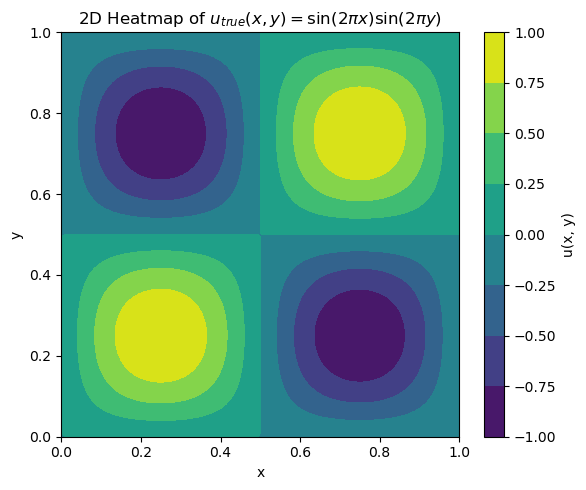

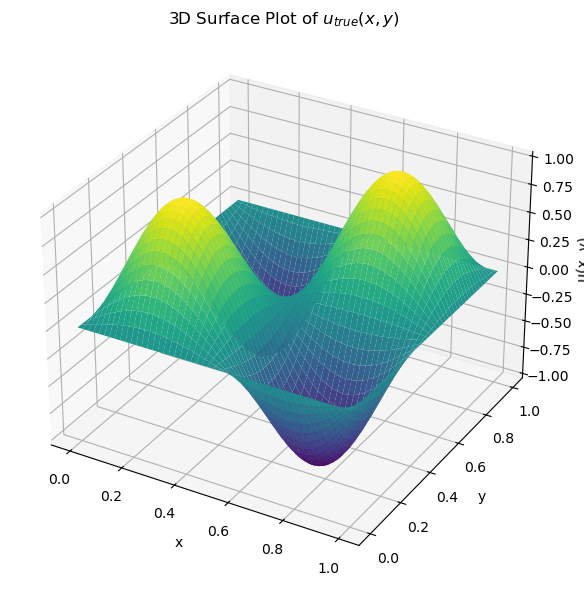

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define domain
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Define exact solution
U = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y)

# 1. 2D Heatmap
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, U, cmap='viridis')
plt.colorbar(label='u(x, y)')
plt.title('2D Heatmap of $u_{true}(x, y) = \sin(2\pi x)\sin(2\pi y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

# 2. 3D Surface Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_title('3D Surface Plot of $u_{true}(x, y)$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x, y)')
plt.tight_layout()
plt.show()


In [2]:
import os, sys
import jax.numpy as jnp
import jax.random as jr
import jax
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from physics.problems import Poisson2D
from train.trainer_single import train_single
from model.pinn_model import PINN

pde = Poisson2D()
u_exact = pde.exact
pde_residual_loss = pde.residual
ansatz = pde.ansatz
domain = pde.domain

In [3]:
n_collocation_points = 600
batch_size = 100     
shuffle = True #shuffle every epoch
steps = 5000
lr = 1e-3
dim = 2

mlp_config = {
    "in_size": 2,
    "out_size": 1,
    "width_size": 128,
    "depth": 5,
    "activation": jax.nn.tanh,
} 

key = jr.PRNGKey(0)
x_collocation = jax.random.uniform(key, (1000, 2), minval=0.0, maxval=1.0)

x_test = jnp.stack(jnp.meshgrid(
    jnp.linspace(0, 1, 50),
    jnp.linspace(0, 1, 50)
), axis=-1).reshape(-1, 2)
print(x_collocation.shape)
print(x_test.shape)

(1000, 2)
(2500, 2)


In [4]:
model = PINN(key, ansatz, input_dim=2)

# 训练
model, train_loss, (test_steps, test_l1) = train_single(
    model=model,
    colloc=x_collocation,
    lr=lr,
    steps=steps,
    batch_size=batch_size,
    pde_residual=pde_residual_loss,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0,
)


PINN: 100%|██████████| 5000/5000 [17:10<00:00,  4.85it/s, l1=1.26e-03, loss=1.07e-02]


In [5]:
### plot
print("u_exact shape:", u_exact(x_test).shape)
print("model shape:", jax.vmap(model)(x_test).shape)

u_exact shape: (2500,)
model shape: (2500, 1)


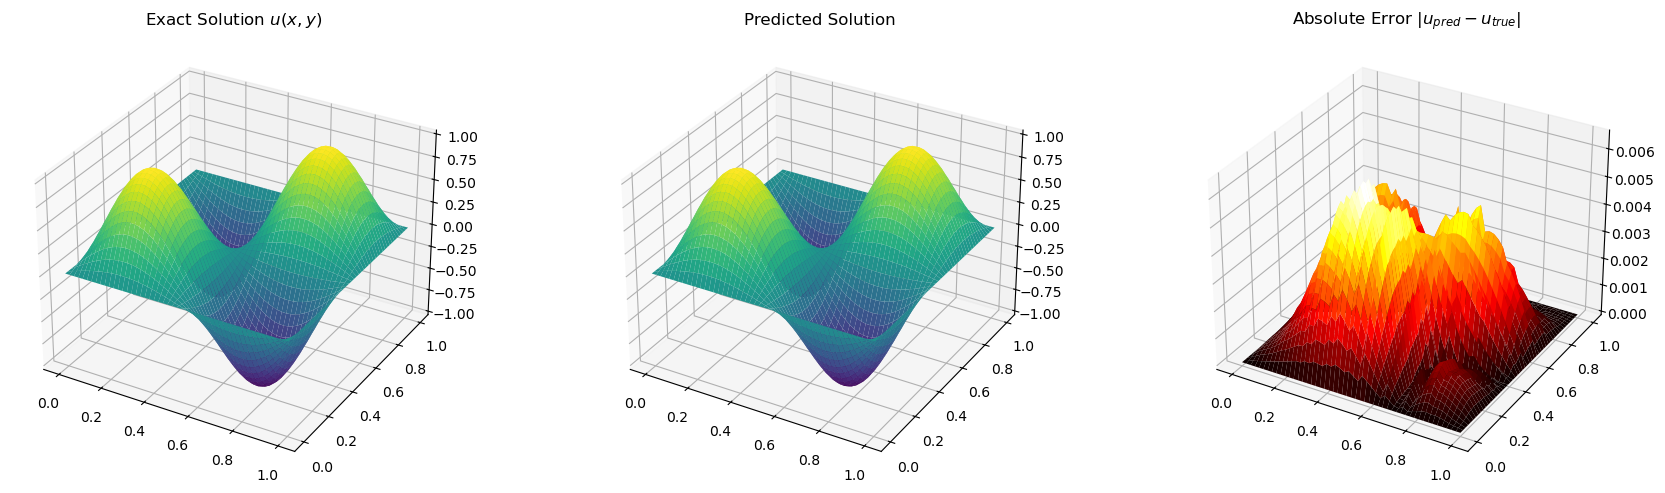

In [8]:
u_pred = jax.vmap(model)(x_test).squeeze()
u_true = u_exact(x_test).squeeze()
error = jnp.abs(u_pred - u_true)

n = int(jnp.sqrt(x_test.shape[0]))
X = x_test[:, 0].reshape(n, n)
Y = x_test[:, 1].reshape(n, n)

# 计算预测与真解
u_pred = jax.vmap(model)(x_test).reshape(n, n)
u_true = u_exact(x_test).reshape(n, n)
error = jnp.abs(u_pred - u_true)

# === 绘图 ===
fig = plt.figure(figsize=(18, 5))

# --- 精确解 ---
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(X, Y, u_true, cmap="viridis")
ax1.set_title("Exact Solution $u(x, y)$")

# --- 预测解 ---
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X, Y, u_pred, cmap="viridis")
ax2.set_title("Predicted Solution")

# --- 误差图 ---
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(X, Y, error, cmap="hot")
ax3.set_title("Absolute Error $|u_{pred} - u_{true}|$")

plt.tight_layout()
plt.show()

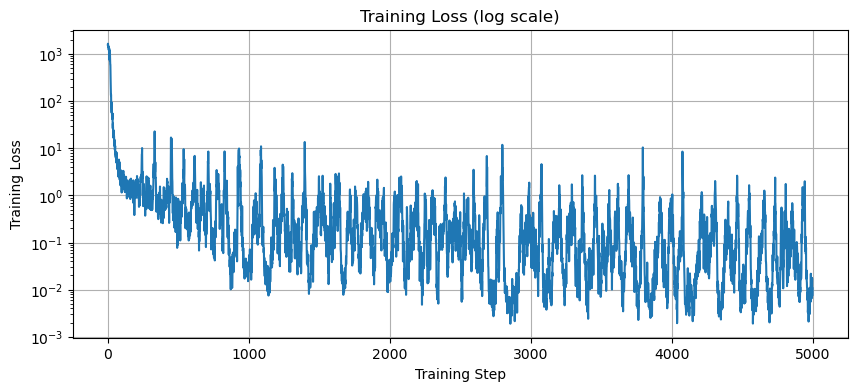

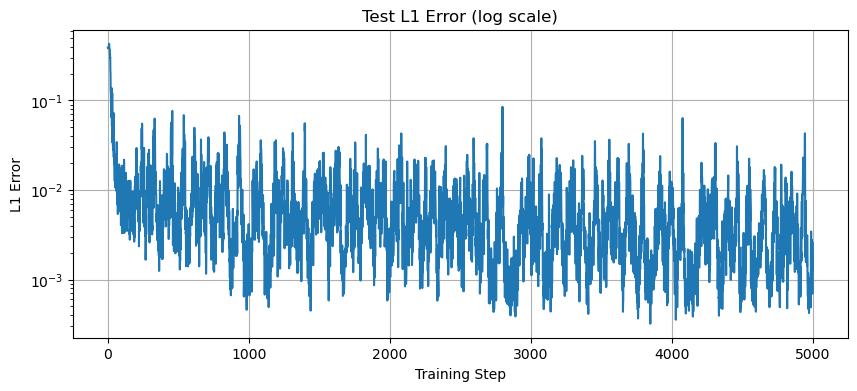

In [11]:
# --- Training Loss 曲线 ---
plt.figure(figsize=(10, 4))
plt.plot(train_loss)
plt.yscale("log")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.title("Training Loss (log scale)")
plt.grid(True)
plt.show()

# --- Test L1 Loss 曲线 ---
plt.figure(figsize=(10, 4))
plt.plot(test_steps, test_l1)
plt.yscale("log")
plt.xlabel("Training Step")
plt.ylabel("L1 Error")
plt.title("Test L1 Error (log scale)")
plt.grid(True)
plt.show()

### FBPINN 

Define the domain decomposition and window functions